### Problem

Burgers equation:
$$\left\{
\begin{array}{l}
u_t + uu_x = \nu u_{xx} \quad x \in [-1, 1], t \in [0, 1] \newline
u(x, 0) = u_0(x) \newline
u(-1, t) = u(1, t) = 0
\end{array}
\right.$$

where $u_0(x) = -\sin(\pi x)$, $\nu = \frac{0.01}{\pi}$

In [ ]:
!pip install pyDOE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=7a8e1f66ae64202db4029e5a29135c623779fdb89cfe0d41055ec6278714fb17
  Stored in directory: /root/.cache/pip/wheels/00/3e/fa/5705bf59c2053c17c4799c3ab66a2e356c32f40a3044fe2134
Successfully built pyDOE


In [ ]:
import tensorflow as tf
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.11.0


In [ ]:
# load data
data = scipy.io.loadmat('data/burgers_shock.mat')

In [ ]:
# Global settings
N_u = 100
N_f = 10000

In [ ]:
# process data

x = data['x'] # 256 points between -1 and 1
t = data['t'] # 100 time points between 0 and 1
usol = data['usol'] # solution of 256 x 100 grid points
X, T = np.meshgrid(x, t)

In [ ]:
# Test data

# 所有的数据都用来测试
# X_u_test = [X[i],T[i]] [25600,2] for interpolation
X_u_test = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

# Domain bounds
lb = X_u_test[0]
ub = X_u_test[-1]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
# 简单理解就是一列一列flatten
# e.g np.array([[1, 2], [3, 4]].flatten()) => [1, 2, 3, 4]
# np.array([[1, 2], [3, 4]].flatten('F')) => [1, 3, 2, 4]
u = usol.flatten('F')[:, None]

In [ ]:
# Training data

# IC
left_x = np.hstack((X[0, :][:, None], T[0, :][:, None]))
left_u = usol[:, 0][:, None]

# BCs
bottom_x = np.hstack((X[:, 0][:, None], T[:, 0][:, None]))
bottom_u = usol[-1, :][:, None]

top_x = np.hstack((X[:, -1][:, None], T[:, 0][:, None]))
top_u = usol[0, :][:, None]

all_X_u_train = np.vstack([left_x, bottom_x, top_x])
all_u_train = np.vstack([left_u, bottom_u, top_u])

# choose random N_u points for training
idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False)

X_u_train = all_X_u_train[idx, :]
u_train = all_u_train[idx, :]

# Collocation Points(PDE)

# Latin Hypercube sampling for collocation points
# N_f set of tuples(x, t)
X_f_train = lb + (ub - lb) * lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train)) # 把边界点也加进pde的训练集中

In [ ]:
class PINN(tf.Module):
    def __init__(self, layers, lb, ub):
        self.weights = [] # weights and bias
        self.num_of_parameters = 0
        self.layers = layers
        self.lb = lb
        self.ub = ub
        self.epoch = 0

        # create weights and bias
        for i in range(len(layers)-1):
            input_dim = layers[i]
            output_dim = layers[i+1]

            # weight
            std = np.sqrt(2 / (input_dim + output_dim))
            w_value = tf.random.normal(shape=(input_dim, output_dim), stddev=std, dtype="float64")
            w = tf.Variable(w_value, trainable=True)
            self.weights.append(w)
            # bias
            b_value = tf.zeros(shape=(output_dim, ), dtype="float64")
            b = tf.Variable(b_value, trainable=True)
            self.weights.append(b)

            # num += num_of_weight + num_of_bias
            self.num_of_parameters += input_dim * output_dim + output_dim

    def __call__(self, X):
        """
        Applying forward pass on dataset X
        """
        x = X
        x = (x - self.lb) / (self.ub - self.lb)

        # applying activation function
        for i in range(len(self.layers)-2):
            # x = activation_function(wx + b)
            x = tf.nn.tanh(tf.add(tf.matmul(x, self.weights[2*i]), self.weights[2*i+1]))

        # output layer
        x = tf.add(tf.matmul(x, self.weights[-2]), self.weights[-1])
        return x

    def loss_BC_IC(self, X_u_train, u_train):

        loss_u = tf.reduce_mean(tf.square(u_train - self(X_u_train)))
        return loss_u

    def loss_PDE(self, X_f_train):
    
        X = tf.Variable(X_f_train, dtype = 'float64', trainable=False)
    
        nu = 0.01/np.pi

        x_f = X[:, 0:1]
        t_f = X[:, 1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            X = tf.stack([x_f[:, 0], t_f[:, 0]], axis=1)   

            u = self(X)
            u_x = tape.gradient(u, x_f)

        u_t = tape.gradient(u, t_f)    
        u_xx = tape.gradient(u_x, x_f)

        del tape

        f = u_t + (u)*(u_x) - (nu)*u_xx

        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f

    def loss(self, X_u_train, u_train, X_f_train):

        loss_u = self.loss_BC_IC(X_u_train, u_train)
        loss_f = self.loss_PDE(X_f_train)

        loss = loss_u + loss_f

        return loss, loss_u, loss_f

    def get_weights(self):
        """
        Return a tensor of model weights' current value
        """

        current_weights_value_tensor = []

        for i in range(len(self.layers)-1):
            # tf.reshape(some_tensor, [-1]) flatten tensors by row
            w_1d = tf.reshape(self.weights[2*i], [-1]) 
            b_1d = tf.reshape(self.weights[2*i+1], [-1])

            # concat flattened weight and bias
            current_weights_value_tensor = tf.concat([current_weights_value_tensor, w_1d], axis=0)
            current_weights_value_tensor = tf.concat([current_weights_value_tensor, b_1d], axis=0)

        return current_weights_value_tensor

    def set_weights(self, parameters):
        """
        Set model weights, given new weights values(stored in parameters)

        Params:
          parameters: a "long" tensor of new model weights, whose size and shape fit the weights returned from self.get_weights()
        """

        # Since `parameters` is a long tensor, we have to destructure it to update model weights.
        # To do that, we need shape and size of each weight and bias

        for i in range(len(self.layers)-1):
            shape_w = tf.shape(self.weights[2*i]).numpy()
            size_w = tf.size(self.weights[2*i]).numpy()

            # pick new weight in `parameters`
            new_w = parameters[0:size_w]
            self.weights[2*i].assign(tf.reshape(new_w, shape_w)) # assign new weight
            parameters = np.delete(parameters, np.arange(size_w), 0) # delete part of `parameters`, whose size fits size of weight

            shape_b = tf.shape(self.weights[2*i+1]).numpy()
            size_b = tf.size(self.weights[2*i+1]).numpy()

            # pick new bias in `parameters`
            new_b = parameters[0:size_b]
            self.weights[2*i+1].assign(tf.reshape(new_b, shape_b)) # assign new bias
            parameters = np.delete(parameters, np.arange(size_b), 0) # delete part of `parameters`, whose size fits size of bias

    def optimizer_func(self, parameters):

        self.set_weights(parameters) # set new weights

        with tf.GradientTape() as tape:
            # Since the class is inheritted from tf.Module,
            # we can use self.trainable_variables to get all trainable variables
            tape.watch(self.trainable_variables)
            
            # loss after update
            loss, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train)

        gradients = tape.gradient(loss, self.trainable_variables)

        del tape

        gradients_1d = [] # flatten grads

        for i in range(len(self.layers)-1):
            gradients_w_1d = tf.reshape(gradients[2*i], [-1]) #flatten weights 
            gradients_b_1d = tf.reshape(gradients[2*i+1], [-1]) #flatten biases

            gradients_1d = tf.concat([gradients_1d, gradients_w_1d], 0) #concat grad_weights 
            gradients_1d = tf.concat([gradients_1d, gradients_b_1d], 0) #concat grad_biases

        return loss.numpy(), gradients_1d.numpy()

    def optimizer_callback(self, parameters):

        loss, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train)

        u_pred = self(X_u_test)
        L2_error = np.linalg.norm((u - u_pred), 2) / np.linalg.norm(u, 2)

        self.epoch += 1
        tf.print(f"epoch: {self.epoch} loss:{loss:.5f} loss_u: {loss_u:.5f} loss_f: {loss_f:.5f} L2_error: {L2_error:.5f}")

In [ ]:
def solutionplot(u_pred,X_u_train,u_train):
    
    fig, ax = plt.subplots()
    ax.axis('off')

    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])

    h = ax.imshow(u_pred, interpolation='nearest', cmap='rainbow', 
                extent=[T.min(), T.max(), X.min(), X.max()], 
                origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)

    line = np.linspace(x.min(), x.max(), 2)[:,None]
    ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    

    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc = 'best')
    ax.set_title('$u(x,t)$', fontsize = 10)
    
    ''' 
    Slices of the solution at points t = 0.25, t = 0.50 and t = 0.75
    '''
    
    ####### Row 1: u(t,x) slices ##################
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

    ax = plt.subplot(gs1[0, 0])
    ax.plot(x,usol.T[25,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[25,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')    
    ax.set_title('$t = 0.25s$', fontsize = 10)
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])

    ax = plt.subplot(gs1[0, 1])
    ax.plot(x,usol.T[50,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[50,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    ax.set_title('$t = 0.50s$', fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

    ax = plt.subplot(gs1[0, 2])
    ax.plot(x,usol.T[75,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,u_pred.T[75,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(x,t)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])    
    ax.set_title('$t = 0.75s$', fontsize = 10)
    
    plt.savefig('Burgers.png',dpi = 500)   

In [ ]:
layers = np.array([2, 30, 30, 30, 1])
model = PINN(layers, lb, ub)

options = {
    'disp': None,
    'maxcor': 200, 
    'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
    'gtol': 5e-8, 
    'maxfun':  50000, 
    'maxiter': 3000,
    'iprint': -1,   #print update every 50 iterations
    'maxls': 50}

results = scipy.optimize.minimize(
    fun=model.optimizer_func,
    x0=model.get_weights().numpy(),
    args=(),
    method='L-BFGS-B',
    jac=True,
    callback=model.optimizer_callback,
    options=options
)

      fun: 0.00035841667978583387
 hess_inv: <1981x1981 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.95058142e-09,  1.49300518e-05, -3.03998412e-05, ...,
       -2.31135156e-04, -7.35168607e-04,  8.88659672e-04])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 3201
      nit: 3000
     njev: 3201
   status: 1
  success: False
        x: array([ 5.85739618,  0.0888944 ,  0.64646595, ..., -0.32117762,
       -0.96086251, -2.55240402])
Test set L2 error: 0.110862


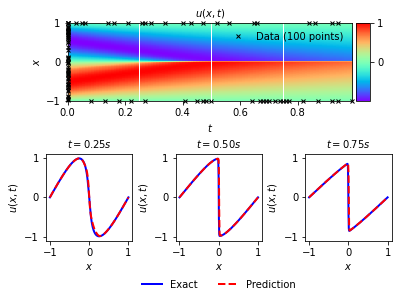

In [ ]:
print(results)
model.set_weights(results.x)

# accuracy
u_pred = model(X_u_test)
L2_error = np.linalg.norm((u - u_pred), 2) / np.linalg.norm(u, 2)
print(f'Test set L2 error: {L2_error:5f}')

u_pred = np.reshape(u_pred,(256,100),order='F') 
''' Solution Plot '''
solutionplot(u_pred,X_u_train,u_train)